In [1]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torchvision
import cv2
import torch

In [2]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torchvision
import cv2
from torch.utils.data import DataLoader

import pandas as pd 
from sklearn.model_selection import train_test_split

label_df = pd.read_csv('./FracAtlas/dataset.csv')
fractured_df = label_df[label_df['fractured'] == 1]
unfractured_df = label_df[label_df['fractured'] == 0]

train_frac_df, val_frac_df = train_test_split(fractured_df, test_size=0.2)
train_unfrac_df, val_unfrac_df = train_test_split(unfractured_df, test_size=0.2)

train_df = pd.concat((train_frac_df, train_unfrac_df))
val_df = pd.concat((val_frac_df, val_unfrac_df))

val_df.reset_index(inplace = True)
train_df.reset_index(inplace = True)

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, annotation_df, img_dir, transform=None, target_transform=None):
        self.img_labels = annotation_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.loc[idx, 'image_id'])
        print(img_path)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = torch.tensor(image).unsqueeze(0)
        label = self.img_labels.loc[idx, 'fractured']
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
transform = transforms.Compose([
    transforms.Resize(300),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(30),  # Randomly rotate the image
    transforms.ColorJitter(brightness=0.5, contrast=0.5),  # Adjust brightness and contrast
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])


train_dataset = CustomImageDataset(train_df, './FracAtlas/images/Compiled/', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True)

val_dataset = CustomImageDataset(val_df, './FracAtlas/images/Compiled/', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=24, shuffle=True)

./FracAtlas/images/Compiled/IMG0003312.jpg
./FracAtlas/images/Compiled/IMG0002569.jpg
./FracAtlas/images/Compiled/IMG0002528.jpg
./FracAtlas/images/Compiled/IMG0003684.jpg
./FracAtlas/images/Compiled/IMG0000833.jpg
./FracAtlas/images/Compiled/IMG0001676.jpg
./FracAtlas/images/Compiled/IMG0003983.jpg
./FracAtlas/images/Compiled/IMG0004070.jpg
./FracAtlas/images/Compiled/IMG0003211.jpg
./FracAtlas/images/Compiled/IMG0001044.jpg
./FracAtlas/images/Compiled/IMG0000979.jpg
./FracAtlas/images/Compiled/IMG0002030.jpg
./FracAtlas/images/Compiled/IMG0002366.jpg
./FracAtlas/images/Compiled/IMG0001429.jpg
./FracAtlas/images/Compiled/IMG0000504.jpg
./FracAtlas/images/Compiled/IMG0003948.jpg
./FracAtlas/images/Compiled/IMG0002320.jpg
./FracAtlas/images/Compiled/IMG0002961.jpg
./FracAtlas/images/Compiled/IMG0002026.jpg
./FracAtlas/images/Compiled/IMG0003793.jpg
./FracAtlas/images/Compiled/IMG0003566.jpg
./FracAtlas/images/Compiled/IMG0002508.jpg
./FracAtlas/images/Compiled/IMG0003608.jpg
./FracAtlas

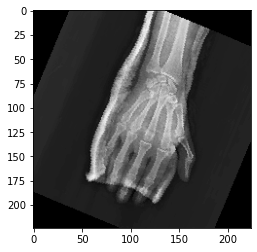

Label: 1


In [7]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [250]:
train_df.columns[9]

'fracture_count'